# Churn forecasting and management

https://www.kaggle.com/pangkw/telco-churn/version/3

__Business case__: Our client is Triple Telco and they provide triple service communication services to consumers (landline phone, fast internet and TV service). Up until a few months ago they were the only triple play provider in their area. However, new provider entered their market and they've seen a dramatic increase in customers who "churn" (i.e. leave).

They hired Bain to help identify drivers of churn and recommend actions to prevent it.

__Note: This notebook will not be shared with trainees__

# Sprint 1

* Load the necessary libraries
* Load the data
* Explore data – what types, any obvious issues
* Run mechanical feature engineering (longest part)
* Split data
* Run logistic regression
* Explore coefficients
* Deep dive on the most predictive data
* Clean-up data (if necessary)
* Re-run logistic regression (if necessary)




## Load all the necessary libraries

In [2]:
%%javascript
// Ensure our output is sufficiently large
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [3]:
# Emnsure all charts plotted automatically
%matplotlib inline

import warnings
import numpy as np
import pandas as pd

import sklearn
import sklearn.linear_model

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_curve, auc
from sklearn import preprocessing

from sklearn_pandas import DataFrameMapper

from xgboost import XGBClassifier

from IPython.display import display, Markdown

import matplotlib.pyplot as plt
import seaborn as sns

# Don't truncate dataframe displays columwise
pd.set_option('display.max_columns', None)  

## Engineer Data: Load the data

You load the CSV data into a Pandas object. This is a common Python library to work with data in row/column format, like .csv files.

Print out top 10 rows just to get a feel for the data

In [4]:


df = pd.read_csv('telco_churn_dataset.csv', sep=',', header=0)
display(df.head(10))
display(df.shape)

,customerID,gender,SeniorCitizen,MaritalStatus,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,InternationalPlan,VoiceMailPlan,NumbervMailMessages,TotalDayMinutes,TotalDayCalls,TotalEveMinutes,TotalEveCalls,TotalNightMinutes,TotalNightCalls,TotalIntlMinutes,TotalIntlCalls,CustomerServiceCalls,TotalCall,TotalHighBandwidthMinutes,TotalHighLatencyMinutes,TotalRevenue,Churn
0,0002-ORFBO,Female,0,Yes,Yes,9,Yes,No,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,No,No,0,168.8,137,241.4,107,204.8,106,15.5,4,0,354,705,119,593.3,No
1,0004-TLHLJ,Male,0,No,No,4,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,Yes,No,0,122.2,112,131.7,94,169.5,106,10.3,9,5,326,292,75,280.9,Yes
2,0013-MHZWF,Female,0,No,Yes,9,Yes,No,DSL,No,No,No,Yes,Yes,Yes,Month-to-month,Yes,Credit card (automatic),No,Yes,36,178.7,134,178.6,102,126.8,82,8.0,4,2,324,1840,257,571.5,No
3,0013-SMEOE,Female,1,Yes,No,71,Yes,No,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),No,No,0,190.2,68,262.2,64,130.0,92,8.8,4,0,228,1389,180,7904.3,No
4,0015-UOCOJ,Female,1,No,No,7,Yes,No,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,No,No,0,67.7,68,195.7,86,236.5,137,12.0,2,1,294,170,1,340.4,No
5,0018-NYROU,Female,0,Yes,No,5,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,No,No,0,174.3,95,186.6,128,258.2,105,12.9,5,3,336,112,17,351.5,No
6,0021-IKXGC,Female,1,No,No,1,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,Yes,No,0,111.9,55,223.0,124,243.2,81,10.0,7,3,270,47,9,72.1,No
7,0022-TCJCI,Male,1,No,No,45,Yes,No,DSL,Yes,No,Yes,No,No,Yes,One year,No,Credit card (automatic),No,No,0,303.2,133,170.5,86,227.6,80,11.5,3,0,302,450,76,2791.5,Yes
8,0030-FNXPP,Female,0,No,No,3,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,No,No,0,60.4,158,306.2,120,123.9,46,12.4,3,1,328,0,0,57.2,No
9,0031-PVLZI,Female,0,Yes,Yes,4,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,No,No,0,321.3,99,167.9,93,193.6,106,8.0,4,1,303,0,0,76.4,Yes


(3333, 35)

__You should see:__

* 3333 rows of data across all 35 columns (different variables)
* lots of rows have text data that needs to be converted into numerical data, ideally one-hot encoded


## Explore the data: 

* Check  for nulls
* Check for outliers on data that is numerical

### Check for nulls and drop if any

In [5]:
# #First replace all empty strings with NAN
df.replace(' ', np.nan,  inplace=True)

# Any null values
df.isnull().sum(axis = 0)

display(df.shape)
df = df.dropna()
display(df.shape)



(3333, 35)

(3328, 35)

__What you should see__:

* We have only 5 null values
 * Think OK to drop
 * In real world, you'd want to document this AND maybe even try to impute the missing number (since only missing Total Reveneu)


### Check for outliers in numerical data 

customerID                    object
gender                        object
SeniorCitizen                  int64
MaritalStatus                 object
Dependents                    object
tenure                         int64
PhoneService                  object
MultipleLines                 object
InternetService               object
OnlineSecurity                object
OnlineBackup                  object
DeviceProtection              object
TechSupport                   object
StreamingTV                   object
StreamingMovies               object
Contract                      object
PaperlessBilling              object
PaymentMethod                 object
InternationalPlan             object
VoiceMailPlan                 object
NumbervMailMessages            int64
TotalDayMinutes              float64
TotalDayCalls                  int64
TotalEveMinutes              float64
TotalEveCalls                  int64
TotalNightMinutes            float64
TotalNightCalls                int64
T

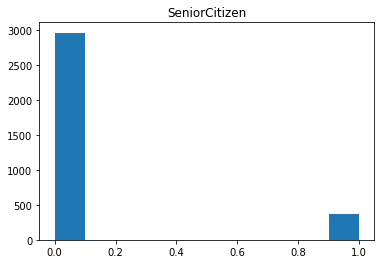

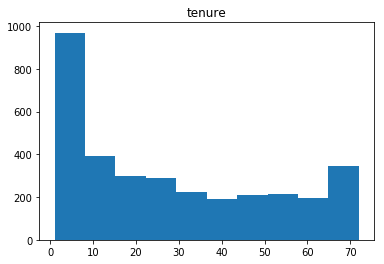

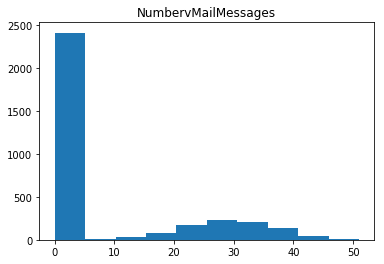

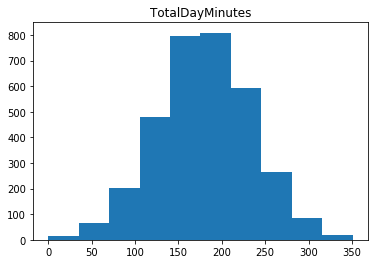

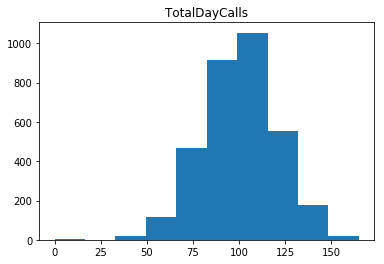

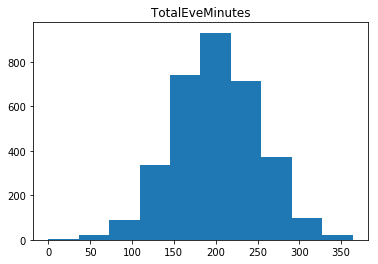

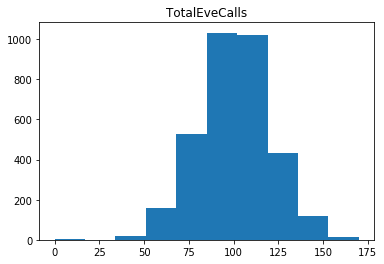

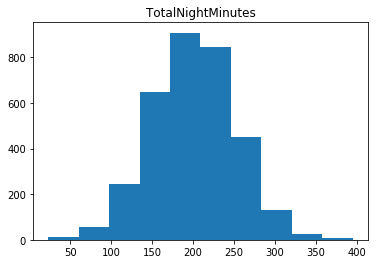

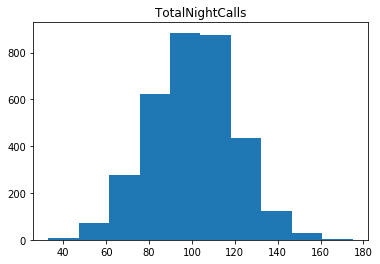

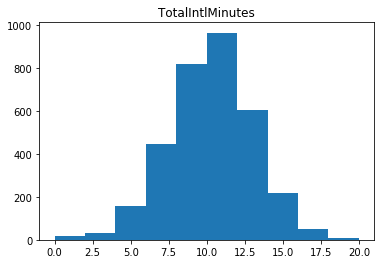

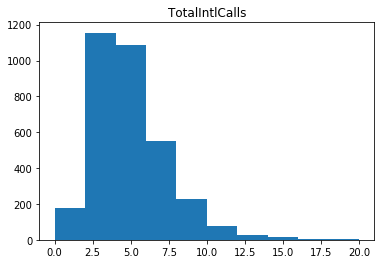

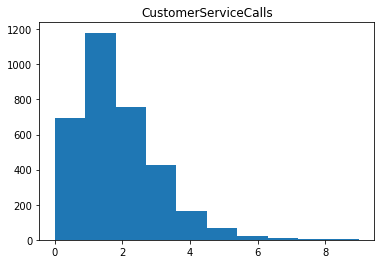

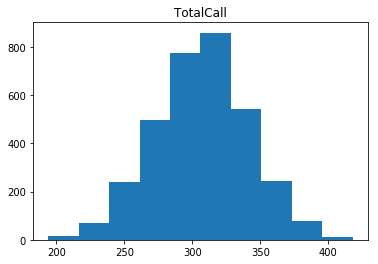

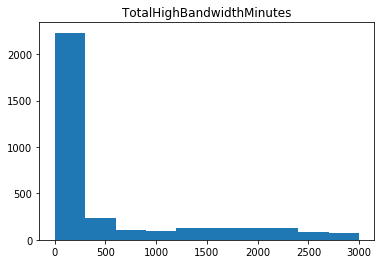

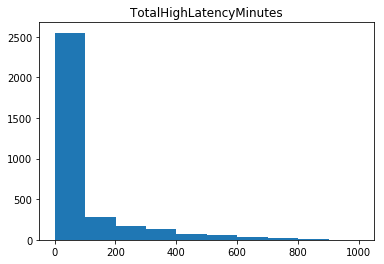

In [6]:
display(df.dtypes)

num_list = list(df.select_dtypes(include=['int64','float64']).columns)
for column in num_list:
    plt.hist(df[column].dropna())
    plt.title(column)
    plt.show()


__What you should see__:
* Nothing too suspicious, think can assume data is clean
* Revenue is not a float or int - we should fix that

In [7]:
df['TotalRevenue']= pd.to_numeric(df['TotalRevenue'], errors='coerce').fillna(0, downcast='infer')

## Mechanical Feature Engineering

In [11]:
# We use capitals for constant variables
TARGET = 'Churn'
ID =  'customerID'
FEATURES = df.columns.tolist()

# Remove customer id - it can't possibly have any predictive power
FEATURES.remove(ID)
#remove target from list of features
FEATURES.remove(TARGET)



encoders = ['gender', 'SeniorCitizen', 'MaritalStatus','Dependents', 'PhoneService',
            'MultipleLines','InternetService', 'OnlineSecurity', 'OnlineBackup',
            'DeviceProtection','TechSupport','StreamingTV','StreamingMovies',
            'Contract', 'PaperlessBilling', 'PaymentMethod', 'InternationalPlan',
            'VoiceMailPlan']

scalars = ['tenure', 'NumbervMailMessages','TotalDayMinutes','TotalDayCalls',
           'TotalEveMinutes', 'TotalEveCalls', 'TotalNightMinutes', 'TotalNightCalls',
           'TotalIntlMinutes','TotalIntlCalls', 'CustomerServiceCalls', 'TotalCall',
           'TotalHighBandwidthMinutes', 'TotalHighLatencyMinutes', 'TotalRevenue']



preprocessing_steps = ([(encoder, preprocessing.LabelBinarizer()) for encoder in encoders] 
                       + [([scalar], preprocessing.StandardScaler()) for scalar in scalars] )

mapper_features = DataFrameMapper(preprocessing_steps)

np_transformed_features = mapper_features.fit_transform(df[FEATURES].copy())
df_transformed_features = pd.DataFrame(data = np_transformed_features, columns = mapper_features.transformed_names_)

mapper_target = DataFrameMapper([(['Churn'],preprocessing.LabelBinarizer())])
numpy_transform_target = mapper_target.fit_transform(df[[TARGET]].copy())

df_transformed_target = pd.DataFrame(data = numpy_transform_target, columns = ['Churn'])



C:\ML\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ML\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ML\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ML\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ML\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.war

## Split data

In [8]:
# The function train_test_split, splits the arguments into two sets.
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(df_transformed_features, df_transformed_target, test_size=0.3, random_state=42, stratify=df_transformed_target)

# Lets verify that our splitting has the same distribution
display(Markdown("__Split in training set__"))
display(pd.Categorical(y_train[TARGET]).describe())
display(Markdown("__Split in test set__"))
display(pd.Categorical(y_test[TARGET]).describe())

__Split in training set__

,counts,freqs
categories,,
0,1872,0.803778
1,457,0.196222


__Split in test set__

,counts,freqs
categories,,
0,803,0.803804
1,196,0.196196


__What you should see__:

* Frequency of No Chrun (0) and yes chrun (1) should be the same in both training and test set
* There should be about 2,300 data-points in training set and about 1000 in the test set

## Develop model: Train and test base-line model
To train and test the base-line model we look at the type of prediction problem we are dealing with. The target is yes or no churn which is a binary outome.
As such our algorithm needs to be able to predict this. A logistic regression is an algorithm that allows to predict binary variable. 

We will:
* Train the model using linear logistic regression
* Test it against unseen data (i.e. test data)
* Show accuracy on seen data and unseen data

*Note for statistics geeks only: The implementation of the algorithm in Python's scikit-learn is not based on ordinary least square or maximum likelihood estimator, which would be the case in R or SAS. Specifically, it penalizes for complexity (called regularization)

In [9]:
# Run Logistic Regression Training
linear_model = sklearn.linear_model.LogisticRegression(random_state=42)
linear_model.fit(X_train, y_train)

display(Markdown('###### Performance on training set'))

y_lr_train = linear_model.predict(X_train)
y_lr_test = linear_model.predict(X_test)
y_lr_test_proba = linear_model.predict_proba(X_test)


# See how well we did
lr_accuracy = sklearn.metrics.accuracy_score(y_train, y_lr_train)
display('Linear model train set accuracy: {:.2f}%'.format(lr_accuracy*100))
display(Markdown('Linear model predicion distribution:'))
display(pd.Categorical(y_lr_test).describe())

lr_accuracy = sklearn.metrics.accuracy_score(y_test, y_lr_test)
display('Linear model test set accuracy: {:.2f}%'.format(lr_accuracy*100))
display(Markdown('Linear model predicion distribution:'))
display(pd.Categorical(y_lr_test).describe())

display(pd.DataFrame(confusion_matrix(y_test, y_lr_test), 
             columns=['Predicted Not Churn', 'Predicted to Churn'],
             index=['Actual Not Churn', 'Actual Churn']))


false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_lr_test_proba[:,1])
roc_auc = auc(false_positive_rate, true_positive_rate)
display(Markdown('\n\nauROC is: {}'.format(roc_auc * 100)))

C:\ML\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ML\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


###### Performance on training set

'Linear model train set accuracy: 86.47%'

Linear model predicion distribution:

,counts,freqs
categories,,
0,861,0.861862
1,138,0.138138


'Linear model test set accuracy: 86.59%'

Linear model predicion distribution:

,counts,freqs
categories,,
0,861,0.861862
1,138,0.138138


,Predicted Not Churn,Predicted to Churn
Actual Not Churn,765,38
Actual Churn,96,100




auROC is: 90.32581899509492

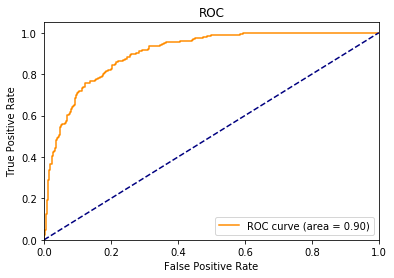

In [10]:
#ROC chart
plt.plot(false_positive_rate, true_positive_rate, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

__What you should see__

* This is pretty good - 86% accuracy (remember overall distribution is 85:15, so a little bit better than a coin-flip)
* AUC is 90 - this is very good for a linear model

* Let's see how these decisions are made

## Explore coefficients

Idea here is to see what the model picked-up to get better understanding why it's predicting churn.

* Explore  intercept
* Explore  coeficients

In [11]:
# get intercept
intercept = linear_model.intercept_

# Get coefficients (same order as features fed into Logistic Regression) and build table
named_coefs = pd.DataFrame({
    'features': df_transformed_features.columns.tolist(),
    'coeficients': linear_model.coef_[0]
}).sort_values('coeficients')

# put it in a nice dataframe and sort from most impact to least, sicne raw print-out is ugly
display("Intercept is {}".format(intercept[0]))
display(named_coefs)

'Intercept is -0.8058042283966471'

,features,coeficients
29,Contract_Two year,-1.674577
36,VoiceMailPlan,-1.457715
37,tenure,-0.862083
24,StreamingMovies_No,-0.784354
6,InternetService_DSL,-0.754558
23,StreamingTV_Yes,-0.646839
28,Contract_One year,-0.625388
15,DeviceProtection_No,-0.472732
25,StreamingMovies_No internet service,-0.400562
19,TechSupport_No internet service,-0.400562


__What you should see__

* list of weights on attributes that drive folks to churn (+ number) or not churn(- number)
* Top five things making folks more likely to churn:
 * International plan - a bit odd - maybe we overcharged them a ton?
 * Contract_Month-to-month - makes a ton of sense, folks are ready to leave
 * Total revenue - seems customers who spend a ton, maybe competitors are cheaper
 * Customer service calls - makes a ton of sense
 * TotalDayMinutes - folks who talk a lot - that's bad - these are probably best customers
 
    
* Top five attributes contributing to not churning:
 * 2 year contract - makes sense - they can't leave without penalty
 * voicemailplan - folks who have voicemail with us - maybe they really like this feature
 * Multiple lines - maybe our competitors don't offer this feature?
 * tenure - folks who are with us for a long time, like to stay with us
 * Contract - one year

# Sprint 2

* Then let's run XGBoost model

* Let's do a bit of feature engineering:
 * Maybe those who have lots of latency when they watch online tv/movies (i.e. share of high bandwidth mintues that are high latency)
 * Those who overpay for services
 


## First - let's run it as XGBoost

In [12]:
XG_model = XGBClassifier()
XG_model.fit(X_train, y_train)

y_predict = XG_model.predict(X_test)
y_predict_proba = XG_model.predict_proba(X_test)

xg_accuracy = sklearn.metrics.accuracy_score(y_test, y_predict)
display('XGBoost model test set accuracy: {:.4f}'.format(xg_accuracy))
display('XGBoost model predicion distribution')
display(pd.Categorical(y_predict).describe())

display(pd.DataFrame(confusion_matrix(y_test, y_predict), 
             columns=['Predicted Not Churn', 'Predicted to Churn'],
             index=['Actual Not Churn', 'Actual Churn']))


false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_predict_proba[:,1])
roc_auc = auc(false_positive_rate, true_positive_rate)
display("auROC is: {}".format(roc_auc * 100))

C:\ML\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ML\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


'XGBoost model test set accuracy: 0.9119'

'XGBoost model predicion distribution'

,counts,freqs
categories,,
0,843,0.843844
1,156,0.156156


,Predicted Not Churn,Predicted to Churn
Actual Not Churn,779,24
Actual Churn,64,132


'auROC is: 94.80074719800747'

___What you should see:___

* Impressive improvment
 * Accuracy up to 91% and auRoc to 95!
 
__What is next__: Let's see feature importnace 

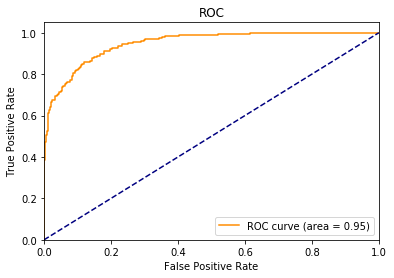

In [13]:
#ROC chart
plt.plot(false_positive_rate, true_positive_rate, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

### Let's understand what's going on with features

In [14]:
pd.DataFrame({'features': df_transformed_features.columns.tolist(), 'importance': XG_model.feature_importances_}).sort_values('importance', ascending=False)

,features,importance
39,TotalDayMinutes,0.188474
41,TotalEveMinutes,0.087227
47,CustomerServiceCalls,0.074766
45,TotalIntlMinutes,0.060748
50,TotalHighLatencyMinutes,0.057632
35,InternationalPlan,0.052960
43,TotalNightMinutes,0.049844
27,Contract_Month-to-month,0.045171
36,VoiceMailPlan,0.042056
37,tenure,0.035826


___What you should see:___

* Seems features around time on the phone are dominating 
* Latency minutes drive some dissatisfaction too
* Contract and tenure too


##  Feature Engineering 

* first let's create a features
* then explore it to see if it may be a signal
* then re-run model with it

Features:
* Latency as share of traffic
* Dollars paid  per service



### First up - Latency minutes - is there a signal here?

* What we care about here is what proportion of time when download speeds are high (e.g. movie watching) also experiences high latency - to do that we'll need to divide high latency minutes by high bandwidth minutes
* Since we scalarized these in our feature-engineered one, we need to work on original dataframe

C:\ML\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Churn,No,Yes
LatencyShareBin,,
"(-0.001, 0.1]",0.876757,0.123243
"(0.1, 0.2]",0.714491,0.285509
"(0.2, 0.3]",0.748641,0.251359
"(0.3, 0.4]",0.111111,0.888889
"(0.4, 0.502]",0.000000,1.000000
All,0.803786,0.196214


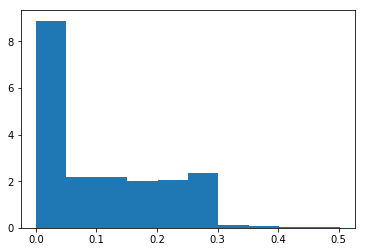

In [15]:
df_latency = pd.DataFrame()
df_latency['Churn'] = df['Churn'].copy()
df_latency['TotalHighBandwidthMinutes'] = df['TotalHighBandwidthMinutes'].copy()
df_latency['TotalHighLatencyMinutes'] = df['TotalHighLatencyMinutes'].copy()
df_latency['Latency_share'] = df_latency['TotalHighLatencyMinutes']/df_latency['TotalHighBandwidthMinutes']
df_latency['Latency_share'] = df_latency['Latency_share'].fillna(0)

plt.hist(df_latency['Latency_share'], normed=True, bins=10)

latency_bins = [df_latency['Latency_share'].min(), .1, .2, .3, .4, df_latency['Latency_share'].max()]
df_latency['LatencyShareBin'] = pd.cut(df_latency['Latency_share'], latency_bins,include_lowest=True).astype(str)

display(pd.crosstab(df_latency['LatencyShareBin'],df_latency['Churn'],normalize='index',margins=True))

       

___What you should see___:

* Looks like most people have latency <5% of total traffic
* For very small group, it goes up above 30%
* Churn doubles for those with latency over 10% of traffi
* Churn is nearly certain for those whose latency is over 30% of traffic

__Takeaway - this a very good feature to add into the model__


 

### Next-up, are people over-paying:

* To do that - we need to: 
 * figure out how much are people paying per month (total rev/tenure)
 * figure out how many services they have (Count phone, interent, tv)
 * figure out what is month charge/service look like
 * Remember, need to look at month-to-month folks only

Churn,No,Yes
num_services,,
1,0.949787,0.050213
2,0.692490,0.307510
3,0.769144,0.230856
All,0.803786,0.196214


Churn,No,Yes,All
num_services,,,
1,1116,59,1175
2,876,389,1265
3,683,205,888
All,2675,653,3328


C:\ML\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\ML\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


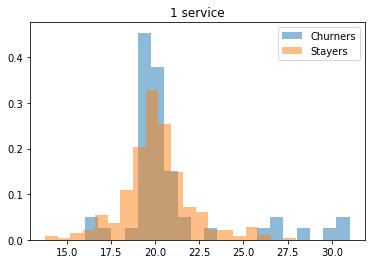

C:\ML\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\ML\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


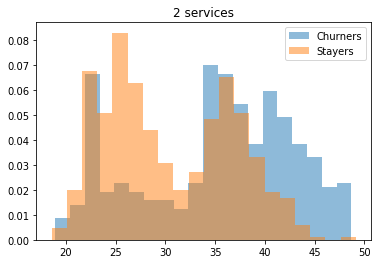

C:\ML\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\ML\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


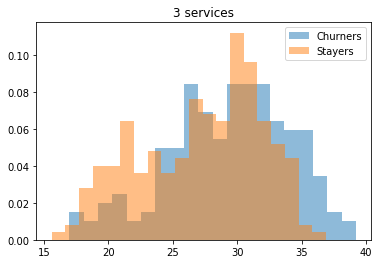

In [16]:
df_overpayment = df.copy()


# Apparently TotalRevnue cannot be downacasted to flaot by auto-magic so forcing it here
df['TotalRevenue']= pd.to_numeric(df['TotalRevenue'], errors='coerce').fillna(0, downcast='infer')

df_overpayment['AvgRevPerMonth'] = df['TotalRevenue'] / df['tenure']
# df_overpayment['num_services'] = df_transformed_features['PhoneService'] + df_transformed_features['InternetService_DSL'] + df_transformed_features['InternetService_Fiber optic'] + df_transformed_features['StreamingTV_Yes'] + 1
df_overpayment['num_services'] = df['PhoneService'].apply(lambda x: 0 if x == "No" else 1)
df_overpayment['num_services'] = df_overpayment['num_services'] + df['InternetService'].apply(lambda x: 0 if x == "No" else 1)
df_overpayment['num_services'] = df_overpayment['num_services'] + df['StreamingTV'].apply(lambda x: 1 if x == "Yes" else 0)

display(pd.crosstab(df_overpayment['num_services'],df_overpayment['Churn'],normalize='index',margins=True))
display(pd.crosstab(df_overpayment['num_services'],df_overpayment['Churn'],margins=True))



df_overpayment['AvgRevPerServicePerMonth'] = df_overpayment['AvgRevPerMonth'] / df_overpayment['num_services']
df_overpayment['AvgRevPerServicePerMonth'] = df_overpayment['AvgRevPerServicePerMonth'].fillna(0)

plt.hist(df_overpayment[(df_overpayment['Churn'] == 'Yes') & (df_overpayment['num_services'] == 1) & (df_overpayment['Contract'] == "Month-to-month")]['AvgRevPerServicePerMonth'].dropna(), bins=20, alpha=0.5, label='Churners', normed = True)
plt.hist(df_overpayment[(df_overpayment['Churn'] == 'No') & (df_overpayment['num_services'] == 1) & (df_overpayment['Contract'] == "Month-to-month")]['AvgRevPerServicePerMonth'].dropna(), bins=20, alpha=0.5, label='Stayers',normed = True)
plt.legend(loc='upper right')
plt.title('1 service')
plt.show()


plt.hist(df_overpayment[(df_overpayment['Churn'] == 'Yes') & (df_overpayment['num_services'] == 2) & (df_overpayment['Contract'] == "Month-to-month")]['AvgRevPerServicePerMonth'].dropna(), bins=20, alpha=0.5, label='Churners', normed = True)
plt.hist(df_overpayment[(df_overpayment['Churn'] == 'No') & (df_overpayment['num_services'] == 2) & (df_overpayment['Contract'] == "Month-to-month")]['AvgRevPerServicePerMonth'].dropna(), bins=20, alpha=0.5, label='Stayers',normed = True)
plt.legend(loc='upper right')
plt.title('2 services')
plt.show()


plt.hist(df_overpayment[(df_overpayment['Churn'] == 'Yes') & (df_overpayment['num_services'] == 3) & (df_overpayment['Contract'] == "Month-to-month")]['AvgRevPerServicePerMonth'].dropna(), bins=20, alpha=0.5, label='Churners', normed = True)
plt.hist(df_overpayment[(df_overpayment['Churn'] == 'No') & (df_overpayment['num_services'] == 3) & (df_overpayment['Contract'] == "Month-to-month")]['AvgRevPerServicePerMonth'].dropna(), bins=20, alpha=0.5, label='Stayers',normed = True)
plt.legend(loc='upper right')
plt.title('3 services')
plt.show()



___What you should see:___

* Looks like folks with multiple services are in fact more likely to churn out, but slightly (crosstab)
* When we plot average dollars paid per service per month we see that regardless of number of services, those with higher price paid are in fact somewhat more likely to churn-out.
* That signal is not very strong, but we can hope that ML algo will be able to make it useful

## Add Features into training/test data set

In [17]:
df_fe = df.copy()

df_fe['Latency_share'] = df_latency['Latency_share'].copy()
df_fe['num_services'] = df_overpayment['num_services'].copy().fillna(0)
df_fe['AvgRevPerServicePerMonth'] = df_overpayment['AvgRevPerServicePerMonth'].copy()

encoders = ['gender', 'SeniorCitizen', 'MaritalStatus','Dependents', 'PhoneService',
            'MultipleLines','InternetService', 'OnlineSecurity', 'OnlineBackup',
            'DeviceProtection','TechSupport','StreamingTV','StreamingMovies',
            'Contract', 'PaperlessBilling', 'PaymentMethod', 'InternationalPlan',
            'VoiceMailPlan']

scalars = ['tenure', 'NumbervMailMessages','TotalDayMinutes','TotalDayCalls',
           'TotalEveMinutes', 'TotalEveCalls', 'TotalNightMinutes', 'TotalNightCalls',
           'TotalIntlMinutes','TotalIntlCalls', 'CustomerServiceCalls', 'TotalCall',
           'TotalHighBandwidthMinutes', 'TotalHighLatencyMinutes', 'TotalRevenue', 
           'Latency_share', 'num_services','AvgRevPerServicePerMonth']

FEATURES = encoders + scalars

preprocessing_steps = ([(encoder, preprocessing.LabelBinarizer()) for encoder in encoders] 
                       + [([scalar], preprocessing.StandardScaler()) for scalar in scalars] )

mapper_features = DataFrameMapper(preprocessing_steps)
np_transformed_features = mapper_features.fit_transform(df_fe[FEATURES].copy())
df_transformed_features = pd.DataFrame(data = np_transformed_features, columns = mapper_features.transformed_names_)

display(df_transformed_features.head(10))

mapper_target = DataFrameMapper([('Churn',preprocessing.LabelBinarizer())])
numpy_transform_target = mapper_target.fit_transform(df[[TARGET]].copy())
df_transformed_target = pd.DataFrame(data = numpy_transform_target, columns = ['Churn'])
display(df_transformed_target.head(10))

FEATURES = mapper_features.transformed_names_
TARGET = 'Churn'



C:\ML\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ML\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ML\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ML\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ML\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.war

,gender,SeniorCitizen,MaritalStatus,Dependents,PhoneService,MultipleLines,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternationalPlan,VoiceMailPlan,tenure,NumbervMailMessages,TotalDayMinutes,TotalDayCalls,TotalEveMinutes,TotalEveCalls,TotalNightMinutes,TotalNightCalls,TotalIntlMinutes,TotalIntlCalls,CustomerServiceCalls,TotalCall,TotalHighBandwidthMinutes,TotalHighLatencyMinutes,TotalRevenue,Latency_share,num_services,AvgRevPerServicePerMonth
0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.819048,-0.591443,-0.201162,1.822232,0.797156,0.345126,0.077336,0.300610,1.884528,-0.194806,-1.187957,1.373011,0.201463,0.200284,-0.562574,0.601707,1.387995,-0.706198
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,-1.034094,-0.591443,-1.056269,0.576343,-1.366832,-0.307390,-0.620583,0.300610,0.022669,1.836258,2.614237,0.559918,-0.314672,-0.082305,-0.725304,1.427629,0.110195,1.015084
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.819048,2.039222,-0.019498,1.672725,-0.441663,0.094158,-1.464808,-0.925845,-0.800846,-0.194806,0.332920,0.501840,1.619898,1.086586,-0.573930,0.328568,1.387995,-0.811978
3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.847520,-0.591443,0.191526,-1.616421,1.207466,-1.813196,-1.401540,-0.414822,-0.514406,-0.194806,-1.187957,-2.285909,1.056273,0.592055,3.245727,0.233982,1.387995,1.276700
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.905066,-0.591443,-2.056340,-1.616421,-0.104341,-0.708939,0.704079,1.884781,0.631353,-1.007232,-0.427518,-0.369332,-0.467139,-0.557569,-0.694310,-0.926346,0.110195,-0.399604
5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.991085,-0.591443,-0.100238,-0.270861,-0.283852,1.399190,1.133111,0.249508,0.953598,0.211406,1.093359,0.850309,-0.539622,-0.454809,-0.688528,0.442173,0.110195,1.019997
6,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,-1.163121,-0.591443,-1.245273,-2.264283,0.434190,1.198416,0.836545,-0.976947,-0.084746,1.023832,1.093359,-1.066269,-0.620854,-0.506189,-0.834068,0.814578,0.110195,1.137907
7,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.729282,-0.591443,2.265068,1.622890,-0.601447,-0.708939,0.528116,-1.028050,0.452329,-0.601019,-1.187957,-0.137019,-0.117216,-0.075883,0.582469,0.602594,0.110195,0.478484
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.077103,-0.591443,-2.190294,2.868779,2.075428,0.997642,-1.522144,-2.765527,0.774573,-0.601019,-0.427518,0.617996,-0.679591,-0.563991,-0.841829,-0.981520,-1.167605,-1.087102
9,

,Churn
0,0
1,1
2,0
3,0
4,0
5,0
6,0
7,1
8,0
9,1


### Split the data

In [18]:
display(Markdown("__Orginal distribution__"))
display(pd.Categorical(df_transformed_target[TARGET]).describe())

# The function train_test_split, splits the arguments into two sets.
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(df_transformed_features[FEATURES], df_transformed_target[TARGET], test_size=0.3, random_state=48879, stratify=df_transformed_target[TARGET])

# Lets verify that our splitting has the same distribution
display(Markdown("__Split in training set__"))
display(pd.Categorical(y_train).describe())
display(Markdown("__Split in test set__"))
display(pd.Categorical(y_test).describe())

__Orginal distribution__

,counts,freqs
categories,,
0,2675,0.803786
1,653,0.196214


__Split in training set__

,counts,freqs
categories,,
0,1872,0.803778
1,457,0.196222


__Split in test set__

,counts,freqs
categories,,
0,803,0.803804
1,196,0.196196


___What you should see___:

* Latency share and AvgRevServicePerMonth are both part of feature set
* We split training and test sets


## Re-run XGBoost

In [19]:
XG_model = XGBClassifier()
XG_model.fit(X_train, y_train)

y_predict = XG_model.predict(X_test)
y_predict_proba = XG_model.predict_proba(X_test)

xg_accuracy = sklearn.metrics.accuracy_score(y_test, y_predict)
display('XGBoost model test set accuracy: {:.4f}'.format(xg_accuracy))
display('XGBoost model predicion distribution')
display(pd.Categorical(y_predict).describe())

display(pd.DataFrame(confusion_matrix(y_test, y_predict), 
             columns=['Predicted Not Churn', 'Predicted to Churn'],
             index=['Actual Not Churn', 'Actual Churn']))


false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_predict_proba[:,1])
roc_auc = auc(false_positive_rate, true_positive_rate)
display("auROC is: {}".format(roc_auc * 100))

'XGBoost model test set accuracy: 0.9209'

'XGBoost model predicion distribution'

,counts,freqs
categories,,
0,848,0.848849
1,151,0.151151


,Predicted Not Churn,Predicted to Churn
Actual Not Churn,786,17
Actual Churn,62,134


'auROC is: 96.4469972297761'

___What you should see___:

* Test set accuracy improved a little bit to 93% from 91%
* auROC improved a little bit too. Now at 94.8 

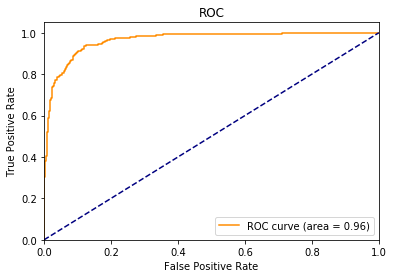

In [20]:
#ROC chart
plt.plot(false_positive_rate, true_positive_rate, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

### Let's look at feature importance

In [21]:
pd.DataFrame({'features': FEATURES, 'importance': XG_model.feature_importances_}).sort_values('importance', ascending=False)


,features,importance
39,TotalDayMinutes,0.192371
47,CustomerServiceCalls,0.092869
54,AvgRevPerServicePerMonth,0.082919
41,TotalEveMinutes,0.081260
45,TotalIntlMinutes,0.053068
52,Latency_share,0.051410
27,Contract_Month-to-month,0.051410
37,tenure,0.049751
35,InternationalPlan,0.048093
43,TotalNightMinutes,0.046434


___What you should see:___

* In fact, we see newly engineered features rising to the top of the importance
 * AvgRevPerServicePerMonth and Latency_share are in top 5
* Oddly - number of services is seemingly not relevant...

## Let's do a little bit of hyper-parameter tuning - let's play with depth only

In [22]:
XG_model = XGBClassifier(max_depth = 8)
XG_model.fit(X_train, y_train)

y_predict = XG_model.predict(X_test)
y_predict_proba = XG_model.predict_proba(X_test)
xg_accuracy = sklearn.metrics.accuracy_score(y_test, y_predict)
display('XGBoost model test set accuracy: {:.4f}'.format(xg_accuracy))
display('XGBoost model predicion distribution')
display(pd.Categorical(y_predict).describe())

display(pd.DataFrame(confusion_matrix(y_test, y_predict), 
             columns=['Predicted Not Churn', 'Predicted to Churn'],
             index=['Actual Not Churn', 'Actual Churn']))


false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_predict_proba[:,1])
roc_auc = auc(false_positive_rate, true_positive_rate)
display("auROC is: {}".format(roc_auc * 100))

'XGBoost model test set accuracy: 0.9309'

'XGBoost model predicion distribution'

,counts,freqs
categories,,
0,834,0.834835
1,165,0.165165


,Predicted Not Churn,Predicted to Churn
Actual Not Churn,784,19
Actual Churn,50,146


'auROC is: 97.12366889470607'

__What you should see:___

*Looks like max-depth of 5 raises auROC just a little bit